In [1]:
#all the imports used in the program

import pandas as pd 
import pyodbc
import numpy as np
import matplotlib.pyplot as plt
import nltk 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.metrics import categorical_accuracy
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Bidirectional, LSTM
from keras.layers import GlobalMaxPool1D, Conv1D, Dropout, GRU, Flatten, MaxPooling1D
from keras.optimizers import Adam
from sklearn.metrics import f1_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
import sklearn.metrics as skm
from sklearn.model_selection import StratifiedKFold

Using TensorFlow backend.


In [2]:
#Grab data from a database

def getData(Server, UID, PWD, Database, query):    
    
    #create a SQL connection based on the given server and database
    sql_conn = pyodbc.connect('DRIVER={SQL Server};'
                              'SERVER='+Server+';' 
                              'UID='+UID+';'
                              'PWD='+PWD+';'
                              'DATABASE='+Database+';' )
    
    #return the data from the given Query and SQL connection,
    #for other instances just simply change or remove depending on use
    return pd.read_sql(query, sql_conn)

In [3]:
#establish my server and corresponding database to pull data from
server ='GSDEMO2HOST'
database = 'MClinical'
UID = 'gsanalytics'
PWD = 'G3st@lt'

#this query grabs sectionValues with their corresponding examCode and description
#does not select examCodes if there is less than 100 section values for the corresponding examCode
#Stores the result in a pandas DataFrame object called data
query = "SELECT CODEKEY.RESULTKEY, CODEKEY.CPT88304, CODEKEY.CPT88305, CODEKEY.CPT88307, CODEKEY.CPT88309, CODEKEY.CPT88331, CODEKEY.CPT88341, CODEKEY.CPT88342, CODEKEY.CPT88112, CODEKEY.CPT88141, CODEKEY.CPT88175, description, ResultSection.sectionValue FROM ResultSection LEFT JOIN CODEKEY ON ResultSection.resultKey = CODEKEY.resultkey LEFT JOIN mapResultRequestedProcedure ON ResultSection.resultKey  = mapResultRequestedProcedure.resultKey LEFT JOIN RequestedProcedure ON mapResultRequestedProcedure.requestedProcedureKey = RequestedProcedure.requestedProcedureKey LEFT JOIN FillerOrder ON RequestedProcedure.fillerOrderKey = FillerOrder.fillerOrderKey LEFT JOIN PlacerOrder ON FillerOrder.placerOrderKey = PlacerOrder.placerOrderKey LEFT JOIN ExamCode ON PlacerOrder.examCodeKey = ExamCode.examCodeKey WHERE sectionValue <> ' ' and ResultSection.sectionCategory like '%gross%' and description is not null and ResultSection.resultKey in ( select CodeKey.resultkey from CodeKey)"


original = getData(server, UID, PWD, database, query)
data = original.copy()


In [4]:
#removes words that have at one colon somewhere in the middle of two words
#and words that have two colons separated by three words. 

def removeColon(df):
    
    #Word array of words that i will later remove
    bagOfWords = []
    
    #a array of every word in the sectionValue on the given dataframe df
    wordList = df.sectionValue.str.split(expand=True).stack()
    
    for word in wordList:
        colonWord = re.search(r"\w+:\w+:\w+", word)
        if colonWord is None:
            colonWord = re.search(r"\w+:\w+", word)
        if colonWord is not None:
            if colonWord.group() not in bagOfWords:
                bagOfWords.append(colonWord.group())
    
    #return the updated dataframe sectionValue, only keeping words that are not contained in bagOfWords            
    return df['sectionValue'].apply(lambda x: ' '.join([word for word in x.split() if word not in (bagOfWords)]))

This method is more useful than it looks.

You pass in a pandas DataFrame and tweak it.

First, i create a empty list called bagOfWords

The next line seemes confusing but bassically what I am doing here is taking every word from the sectionValue column and creating a list in which each row only contains one word. This helps with the iterative process. I store the result of this into WordList(approx 1.4 million words)

Next, i iterate through every word in the wordList in a for loop.

let me explain how the search process works and what words i am looking to add to my bagOfWords
1. How does the search processWork?
    1. I use Regex(regular expression) to do my searching for me which is on a character by character basis
2. What kind of words am i looking for?
    1. \w+:\w+ and \w+:\w+:\w+
        1. \w searches for any character in the form [a-zA-Z0-9]
        2. \+ searches for the previous search condition until the end of the word. 
        3. : specifies that i want a colon 
        4. putting it all together 
            1. \w+:\w+ searches for a character in the form [a-zA-Z0-9] for any amount of characters in that form until it hits a colon : in which then it does the same \w+ until the end of the word.
            2. \w+:\w+:\w+ is the same as above just has two colons i hope you get the picture..
            
     
Since i am searching for two different types of words i need to search two different times for every word in wordList.

I search the word to see if it matches the pattern of having three words separated by 2 colons, this returns a match object which i store in colonWord.

if the word isnt found in the search it returns None, so i check if colonWord is None. If it is i search for the different type of word and store that searches result into colonWord.

After that process is done i finally check to see if either of my searches came back true(not None)

If they do i use colonWord.group() function to grab just the string(word) that it found.

Then Check the bagOfWords to see if the word i found is already in it. 

If the word is already in it I move onto the next word in the wordList.

if it is not, i simply  add it and move to the next word as well. 

Finally once i have scanned all words and created my bagOfWords that is a unique list i remove those words from the sectionValue column of the Data. 

what the last line in the funtion is doing is recreating my column sectionValue, but only keeping words that are NOT in bagOfWords.

Once that is done i return the new column of sectionValue. 

In [5]:
#here i wanted to remove punctuation from the column sectionValue in my pandas dataFrame
#i replace every character that matches with one of the following below with nothing.

def removePunctuation(df1):
    df1['sectionValue'] = df1['sectionValue'].str.replace(',', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('.', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('?', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('/', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('/', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('+', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('-', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('=', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('_', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace(')', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('(', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('*', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('&', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('^', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('%', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('$', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('#', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('@', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('!', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('>', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('<', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('[', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace(']', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('{', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('}', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('|', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace(':', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace(';', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('\'', '')
    df1['sectionValue'] = df1['sectionValue'].str.replace('\"', '')
    return df1
    

In [6]:
def removeStopWords(df):
    
    #stopWords are words that have relatively no meaning to any actual data
    #we dont want that here so lets remove them
    stop = stopwords.words('english')
    
    # add custom stopWords 
    stop = addStopWords(stop)
    
    # add this if you want to remove words that are smaller than size two
    # change the size to whatever you like 
    
    #df['sectionValue'] = df['sectionValue'].apply(lambda x: ' '.join([word for word in x.split() if len(word) > 2]))
    
    #returning the new sectionValue to the Datafram with words that are not in the StopWords
    return df['sectionValue'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


In [7]:
#adding my own custom stopWords
#super simple to add as you can see 
#modify as needed!

def addStopWords(stop):
    stop.append('-')
    stop.append('a')
    stop.append('b')
    stop.append('c')
    stop.append('d')
    stop.append('e')
    stop.append('f')
    stop.append('g')
    stop.append('h')
    stop.append('i')
    stop.append('j')
    stop.append('k')
    stop.append('l')
    stop.append('m')
    stop.append('n')
    stop.append('o')
    stop.append('p')
    stop.append('q')
    stop.append('r')
    stop.append('s')
    stop.append('t')
    stop.append('u')
    stop.append('v')
    stop.append('w')
    stop.append('x')
    stop.append('y')
    stop.append('z')
    stop.append('no')
    stop.append('see')
    stop.append('two')
    stop.append('0')
    stop.append('1')
    stop.append('2')
    stop.append('3')
    stop.append('4')
    stop.append('5')
    stop.append('6')
    stop.append('7')
    stop.append('8')
    stop.append('9')
    return stop

In [8]:
#clean_text transforms words like tomatoes, tomato, tomatos, all to tomato. this is very helpful.

nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = re.sub(r'[^\w\s]','',text, re.UNICODE)
    text = [lemmatizer.lemmatize(token) for token in text.split(" ")]
    text = [lemmatizer.lemmatize(token, "v") for token in text]
    text = " ".join(text)
    return text

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\csorensen\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [9]:
#concatinate the sectionValue and description feild
def concatExamDesc(df):
    return  df['description'] + ' ' + df['sectionValue']

In [10]:
def clean(df):
    #change the case of all the words to lower case so there is no case sensitivity.
    df['sectionValue'] = df['sectionValue'].str.lower()

    #call the removeColon function to remove words with a colon or mulitple colons in the middle of the word
    df['sectionValue'] = removeColon(df)

    #call the removePuncuation code, notice how i did this after the removeColon function.
    #it is important that we call this after the removeColon Function because this would remove colons
    #from words we want to remove, and then the remove colon function would never find anything because there is no colons. 
    df = removePunctuation(df)

    #call the removeStopWords function to remove words that have no meaning.
    df['sectionValue'] = removeStopWords(df)

    #call the clean_text to place words of simularity with the base word (ex: biopsies -> biopsy)
    df['sectionValue'] = df.sectionValue.apply(lambda x: clean_text(x))

    #add the description to the sectionValue
    df['sectionValue'] = concatExamDesc(df)
    return df['sectionValue']

In [11]:
data['sectionValue'] = clean(data)
data.sectionValue.apply(lambda x: len(x.split(" "))).mean()

103.76511226252158

In [12]:
def convert_text(df, maxlen, max_words):
    #split df into two series
    #texts being the sectionValue
    #labels being the cooresponding examCode
    texts = df.sectionValue
    
    #convert the series into numpy arrays
    texts = texts.values
    
    #create a tokenizer based on the max_words
    #fit the tokenizer to our specific texts
    #change our texts to a vetorized integer
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)

    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))
    
    #pad sequences ensures that all our vectors are of the same length
    x = pad_sequences(sequences, maxlen=maxlen)
    
    
    #create a dictionary to map all
    #cpt codes to 1 and keep other values as 0
    d = defaultdict(LabelEncoder)
    
    fit = df[['CPT88304', 'CPT88305', 'CPT88307',
            'CPT88309', 'CPT88331', 'CPT88341', 
            'CPT88342', 'CPT88112', 'CPT88141', 
            'CPT88175']].apply(lambda y: d[y.name].fit_transform(y))   
    labels = fit.values

    print('Shape of data tensor:', x.shape)
    print('Shape of label tensor:', labels.shape)

    #we need to randomize the indexs of our data because we had 
    #entered it all in ordely fashion. we dont want that. 
    #our model wouldnt learn correctly if it was ordered by examCode..
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    x = x[indices]
    labels = labels[indices]
    
    #return x, labels, and the last 7000 of x and labels for testing
    return x[:35000], labels[:35000], x[-35059:], labels[-35059:]

In [13]:
#define maxlen as the maximum words to take from each sectionValue
#define max_words as the total number of unique words to tokenize

maxlen = 150
max_words = 24000

#create data that can be ran through our model
x_train, y_train, x_test, y_test = convert_text(data, maxlen, max_words)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

Found 23618 unique tokens.
Shape of data tensor: (70059, 150)
Shape of label tensor: (70059, 10)
(35000, 150)
(35000, 10)
(35059, 150)
(35059, 10)


In [14]:
#create a machine learning model with the following
def create_model(max_words,maxlen):
    #keras default model
    model = Sequential()
    
    #add an embedding layer with the input dim and input length to what we have already
    #configured for our vectorized forms of our text
    
    #135 BEST THIS FAR .1443 LOSS
    #JUST A EMMBEDING LAYER, AND A GLOBAL MAX POOLING
    
    
    
    #ADD DROPOUT .15 THEN CONV1D .1393 LOSS EPOCH 3
    model.add(Embedding(max_words,135, input_length=maxlen, embeddings_initializer="uniform"))
    
    #model.add(Bidirectional(LSTM(64)))
    
    model.add(Dropout(0.15))
    
    model.add(Conv1D(maxlen, 3, padding='valid', activation='relu', strides=1))
    #model.add(Dropout(0.15))
    
    #model.add(Conv1D(maxlen, 3, padding='valid', activation='relu', strides=1))
    #model.add(Dropout(0.15))
    #model.add(Conv1D(maxlen, 3, padding='valid', activation='relu', strides=1))
    #model.add(Dropout(0.15))
    #model.add(Conv1D(maxlen, 3, padding='valid', activation='relu', strides=1))
    #model.add(Bidirectional(LSTM(256)))
    model.add(GlobalMaxPool1D())
    # create a dense output layer with the units = len(labels_dict)
    model.add(Dense(10, activation='sigmoid'))
    
    #print the summary
    model.summary()
    
    return model

In [15]:
#create the model
model = create_model(max_words, maxlen)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 150, 135)          3240000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 150, 135)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 148, 150)          60900     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 150)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1510      
Total params: 3,302,410
Trainable params: 3,302,410
Non-trainable params: 0
___________

In [16]:
#train the model
def train_model(model, x_train, y_train, epochs, batchsize, max_words, max_len):
    #compile the model
    #optimizer -> adam (better for multi-label applications)
    #loss -> sbinary_crossentropy(we are using this because each label is a unique binary case)
    #meteric -> accuracy
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['acc']) 
    #save the history from the model
    #set the paramiters
    #fit the model 
    history = model.fit(x_train, 
                        y_train,
                        epochs=epochs,
                        batch_size=batchsize,
                        validation_split=0.2)
    return history

In [17]:
#train the model
history = train_model(model, x_train, y_train, 4, 100, max_words, maxlen)

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Train on 28000 samples, validate on 7000 samples
Epoch 1/4
28000/28000 [==============================] - 68s 2ms/step - loss: 0.1578 - acc: 0.9469 - val_loss: 0.0767 - val_acc: 0.9719
Epoch 2/4
28000/28000 [==============================] - 66s 2ms/step - loss: 0.0659 - acc: 0.9761 - val_loss: 0.0646 - val_acc: 0.9762
Epoch 3/4
28000/28000 [==============================] - 65s 2ms/step - loss: 0.0550 - acc: 0.9802 - val_loss: 0.0604 - val_acc: 0.9781
Epoch 4/4
28000/28000 [==============================] - 68s 2ms/step - loss: 0.0477 - acc: 0.9829 - val_loss: 0.0586 - val_acc: 0.9785


In [18]:
#generate the report for the training process
def training_report(history):
    #get the data from the model history file 
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    #set our epochs
    epochs = range(1, len(acc) + 1)

    #plot the accuracy 
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()
    
    #plot the loss
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

    #display the max values we attained
    print('Validation Accuracy: ', val_acc[np.argmax(val_acc)] * 100)
    print('Training Accuracy: ', acc[np.argmax(acc)] * 100)

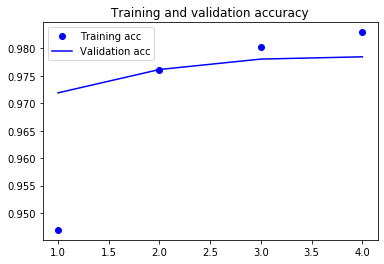

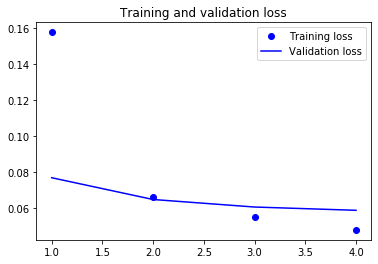

Validation Accuracy:  97.84714077200208
Training Accuracy:  98.29499806676593


In [19]:
training_report(history)

In [20]:
#test the model on our set aside testing data
def test_model(model, x_test):
    #gather the models prediction 
    
    #the model displays its prediction as a list of all the cpt codes 
    #with percents in each category at how confident the model is for 
    #each cptCode. 
    
    #since we used a binary classifier
    #anything above .5 will  be considered true
    #and anything below .5 will be considered false
    preds = model.predict(x_test)
    
    #for every row in the prediction list
    #change every column value for the specific row
    #where the percent is above or equal to .5 to 1 
    #and below .5 to 0
    preds[preds>=0.5] = 1
    preds[preds<0.5] = 0
    
    #convert the list to a numpy array
    return np.asarray(preds)

In [21]:
#test the model against our test data and store the predictions in y_pred
y_pred = test_model(model, x_test)

In [22]:
#create the confusion matrix
def test_confusion_matrix(y_pred,y_test):
    matrix = skm.multilabel_confusion_matrix(y_test, y_pred)
    
    #create a label_dict
    temp = ['88304', '88305', '88307',
            '88309', '88331', '88341', 
            '88342', '88112', '88141', 
            '88175']
    label_dict = np.asarray(temp)


    #print the confusion matrix 
    #rows are the models predictions
    #columns is the test

    #since the matrix is of shape 10 x 2 x 2 
    #we will go through each 2 x 2 matrix to display
    #each cpt codes individual confusion matrix

    x = 0
    for i in matrix:
        #convert matrix to a pandas df to convert
        #index and columns to cpt codes
        print(x)
        dfmatrix = pd.DataFrame(i, columns=[0,label_dict[x]], index=[0,label_dict[x]])
        print(dfmatrix, '\n\n')
        x = x+1

    

In [23]:
#create the classification report
def test_classification_report(y_pred,y_test):
    #cr
    print(skm.classification_report(y_test, y_pred))

In [29]:
def test_accuracy(y_pred, y_test):
    #accuracy
    print('Test accuracy : ',(1 - skm.hamming_loss(y_test, y_pred)) * 100)

In [30]:
#display the accuracy of the predictions
test_accuracy(y_pred, y_test)

Test accuracy :  97.90353404261388


In [31]:
#display the confusion of each category predictions
test_confusion_matrix(y_pred,y_test)

0
           0  88304
0      30796    225
88304    615   3423 


1
          0  88305
0      6685    989
88305   805  26580 


2
           0  88307
0      28185    530
88307    556   5788 


3
           0  88309
0      33690    135
88309    482    752 


4
           0  88331
0      33383     42
88331     77   1557 


5
           0  88341
0      32600    337
88341   1144    978 


6
           0  88342
0      28684    615
88342    797   4963 


7
           0  88112
0      35058      0
88112      1      0 


8
           0  88141
0      35059      0
88141      0      0 


9
           0  88175
0      35059      0
88175      0      0 




In [32]:
#display the classification report on the predictions
test_classification_report(y_pred, y_test)

              precision    recall  f1-score   support

           0       0.94      0.85      0.89      4038
           1       0.96      0.97      0.97     27385
           2       0.92      0.91      0.91      6344
           3       0.85      0.61      0.71      1234
           4       0.97      0.95      0.96      1634
           5       0.74      0.46      0.57      2122
           6       0.89      0.86      0.88      5760
           7       0.00      0.00      0.00         1
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.91      0.92     48518
   macro avg       0.63      0.56      0.59     48518
weighted avg       0.93      0.91      0.92     48518
 samples avg       0.96      0.95      0.94     48518



C:\Users\csorensen\.conda\envs\test\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\csorensen\.conda\envs\test\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\csorensen\.conda\envs\test\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


In [33]:
#same as convert_text just no training/test split
def convert_text_no_split(df, maxlen, max_words):
    #split df into two series
    #texts being the sectionValue
    #labels being the cooresponding examCode
    texts = df.sectionValue
    
    #convert the series into numpy arrays
    texts = texts.values
    
    #create a tokenizer based on the max_words
    #fit the tokenizer to our specific texts
    #change our texts to a vetorized integer
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)

    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))
    
    #pad sequences ensures that all our vectors are of the same length
    x = pad_sequences(sequences, maxlen=maxlen)

    #create a dictionary to map all
    #cpt codes to 1 and keep other values as 0
    d = defaultdict(LabelEncoder)
    
    fit = df[['CPT88304', 'CPT88305', 'CPT88307',
            'CPT88309', 'CPT88331', 'CPT88341', 
            'CPT88342', 'CPT88112', 'CPT88141', 
            'CPT88175']].apply(lambda y: d[y.name].fit_transform(y))   
    labels = fit.values

    print('Shape of data tensor:', x.shape)
    print('Shape of label tensor:', labels.shape)

    #we need to randomize the indexs of our data because we had 
    #entered it all in ordely fashion. we dont want that. 
    #our model wouldnt learn correctly if it was ordered by examCode..
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    x = x[indices]
    labels = labels[indices]
    
    #return x, labels, and the last 7000 of x and labels for testing
    return x, labels

In [34]:
#create a method to completely train and evaluate the model
def train_and_evaluate_model(model, x_train, y_train, x_test, y_test):
    #train the model with 21 epochs 
    history = train_model(model, x_train, y_train, 4, 100, max_words, maxlen)
    
    #print the graphs for loss and accuracy
    training_report(history)
    
    #get the predictions on the test data
    y_pred = test_model(model, x_test)
    
    #print the confusion matrix of each category
    test_confusion_matrix(y_pred,y_test)
    
    #print the accuracy of the predictions
    test_accuracy(y_pred,y_test)
    
    #return the classification report
    return skm.classification_report(y_test, y_pred)

In [35]:
#this just is so that the kfolds can split the indices, really just creating a array that is not multi label
def get_new_labels(y):
    #only have one column, each column only containing ones...
    y_new = LabelEncoder().fit_transform([''.join(str(l)) for l in y])
    #return y_new
    return y_new

Found 23618 unique tokens.
Shape of data tensor: (70059, 150)
Shape of label tensor: (70059, 10)


C:\Users\csorensen\.conda\envs\test\lib\site-packages\sklearn\model_selection\_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)


Running Fold 1 / 10 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 150, 135)          3240000   
_________________________________________________________________
dropout_2 (Dropout)          (None, 150, 135)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 148, 150)          60900     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 150)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1510      
Total params: 3,302,410
Trainable params: 3,302,410
Non-trainable params: 0
_________________________________________________________________
Train on 50416 samples, validate on 12604 samples
Epoch 1/4
50416/50416 [==============================] - 11

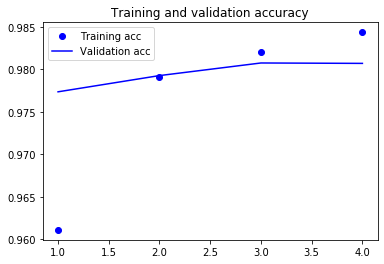

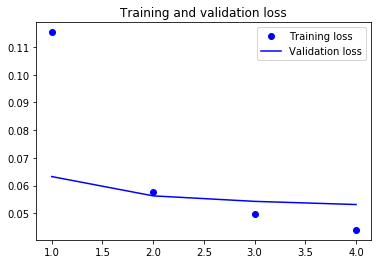

Validation Accuracy:  98.0744189759808
Training Accuracy:  98.43640747627582
0
          0  88304
0      6184     42
88304   107    706 


1
          0  88305
0      1419    130
88305   221   5269 


2
          0  88307
0      5635    115
88307    85   1204 


3
          0  88309
0      6736     46
88309    53    204 


4
          0  88331
0      6685     10
88331    17    327 


5
          0  88341
0      6487    129
88341   163    260 


6
          0  88342
0      5771    107
88342   177    984 


7
          0  88112
0      7039      0
88112     0      0 


8
          0  88141
0      7039      0
88141     0      0 


9
          0  88175
0      7039      0
88175     0      0 


Test accuracy :  98.00823980679074



Running Fold 2 / 10 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 150, 135)          3240000   
____________________________________________

C:\Users\csorensen\.conda\envs\test\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\csorensen\.conda\envs\test\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
C:\Users\csorensen\.conda\envs\test\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels.
  'precision', 'predicted', average, warn_for)


Train on 50428 samples, validate on 12608 samples
Epoch 1/4
50428/50428 [==============================] - 131s 3ms/step - loss: 0.1142 - acc: 0.9601 - val_loss: 0.0633 - val_acc: 0.9769
Epoch 2/4
50428/50428 [==============================] - 134s 3ms/step - loss: 0.0568 - acc: 0.9795 - val_loss: 0.0581 - val_acc: 0.9789
Epoch 3/4
50428/50428 [==============================] - 129s 3ms/step - loss: 0.0491 - acc: 0.9824 - val_loss: 0.0555 - val_acc: 0.9797
Epoch 4/4
50428/50428 [==============================] - 137s 3ms/step - loss: 0.0431 - acc: 0.9847 - val_loss: 0.0558 - val_acc: 0.9795


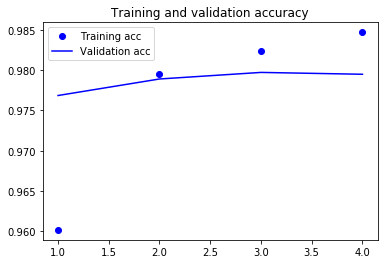

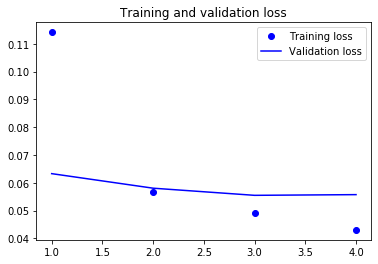

Validation Accuracy:  97.9727130742545
Training Accuracy:  98.47207745392222
0
          0  88304
0      6186     27
88304   130    680 


1
          0  88305
0      1367    171
88305   175   5310 


2
          0  88307
0      5636    106
88307    91   1190 


3
          0  88309
0      6735     38
88309    71    179 


4
          0  88331
0      6681     10
88331    22    310 


5
          0  88341
0      6450    156
88341   127    290 


6
          0  88342
0      5693    179
88342   138   1013 


7
          0  88112
0      7023      0
88112     0      0 


8
          0  88141
0      7023      0
88141     0      0 


9
          0  88175
0      7023      0
88175     0      0 


Test accuracy :  97.94817029759362



Running Fold 3 / 10 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 150, 135)          3240000   
____________________________________________

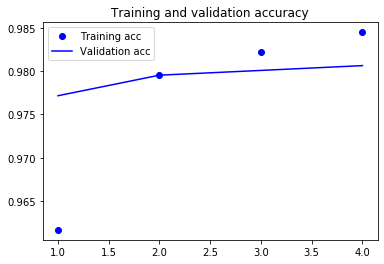

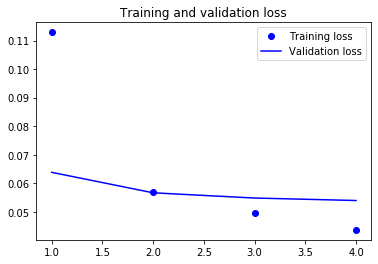

Validation Accuracy:  98.0639250580278
Training Accuracy:  98.44899907433971
0
          0  88304
0      6154     56
88304    98    711 


1
          0  88305
0      1374    163
88305   165   5317 


2
          0  88307
0      5629    112
88307    91   1187 


3
          0  88309
0      6721     49
88309    38    211 


4
          0  88331
0      6665     25
88331     7    322 


5
          0  88341
0      6505     99
88341   176    239 


6
          0  88342
0      5759    114
88342   171    975 


7
          0  88112
0      7019      0
88112     0      0 


8
          0  88141
0      7019      0
88141     0      0 


9
          0  88175
0      7019      0
88175     0      0 


Test accuracy :  98.05670323407892



Running Fold 4 / 10 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 150, 135)          3240000   
____________________________________________

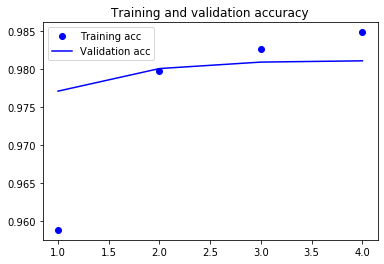

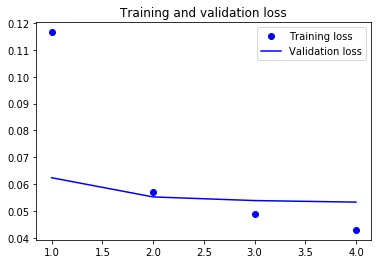

Validation Accuracy:  98.10626295045857
Training Accuracy:  98.48144025955395
0
          0  88304
0      6140     67
88304   110    696 


1
          0  88305
0      1417    120
88305   204   5272 


2
          0  88307
0      5642    100
88307    99   1172 


3
          0  88309
0      6733     33
88309    65    182 


4
          0  88331
0      6672     12
88331    17    312 


5
          0  88341
0      6544     56
88341   224    189 


6
          0  88342
0      5778     88
88342   157    990 


7
          0  88112
0      7013      0
88112     0      0 


8
          0  88141
0      7013      0
88141     0      0 


9
          0  88175
0      7013      0
88175     0      0 


Test accuracy :  98.07215171823755



Running Fold 5 / 10 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 150, 135)          3240000   
___________________________________________

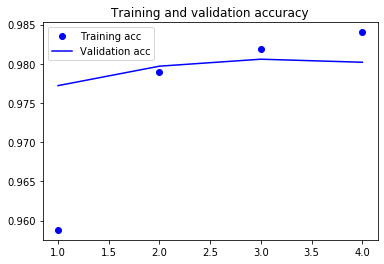

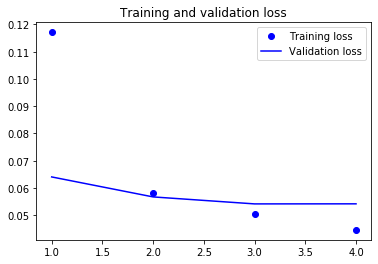

Validation Accuracy:  98.05804191672843
Training Accuracy:  98.40186230017022
0
          0  88304
0      6159     43
88304   119    687 


1
          0  88305
0      1371    164
88305   161   5312 


2
          0  88307
0      5652     88
88307   110   1158 


3
          0  88309
0      6736     28
88309    78    166 


4
          0  88331
0      6681      3
88331     9    315 


5
          0  88341
0      6452    142
88341   134    280 


6
          0  88342
0      5729    133
88342   153    993 


7
          0  88112
0      7008      0
88112     0      0 


8
          0  88141
0      7008      0
88141     0      0 


9
          0  88175
0      7008      0
88175     0      0 


Test accuracy :  98.05222602739725



Running Fold 6 / 10 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 150, 135)          3240000   
___________________________________________

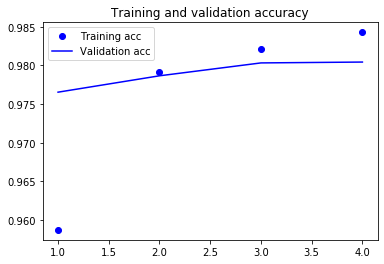

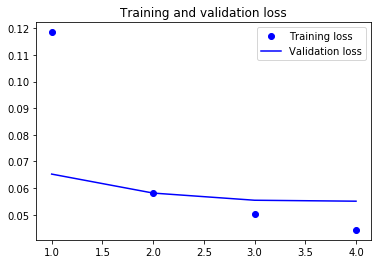

Validation Accuracy:  98.04313199277382
Training Accuracy:  98.4285530445833
0
          0  88304
0      6155     43
88304   101    704 


1
          0  88305
0      1343    191
88305   186   5283 


2
          0  88307
0      5637    100
88307   103   1163 


3
          0  88309
0      6735     26
88309    79    163 


4
          0  88331
0      6671      9
88331    17    306 


5
          0  88341
0      6508     80
88341   154    261 


6
          0  88342
0      5781     79
88342   191    952 


7
          0  88112
0      7003      0
88112     0      0 


8
          0  88141
0      7003      0
88141     0      0 


9
          0  88175
0      7003      0
88175     0      0 


Test accuracy :  98.0594031129516



Running Fold 7 / 10 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 150, 135)          3240000   
_____________________________________________

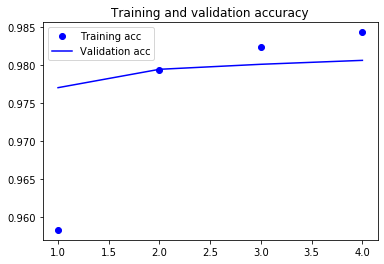

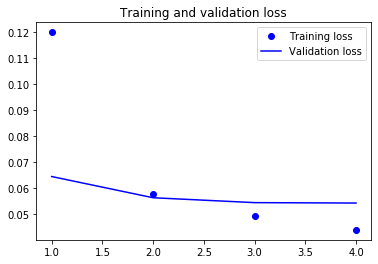

Validation Accuracy:  98.06057538186185
Training Accuracy:  98.42943907915964
0
          0  88304
0      6172     26
88304   147    655 


1
          0  88305
0      1398    131
88305   192   5279 


2
          0  88307
0      5616    119
88307    74   1191 


3
          0  88309
0      6731     29
88309    68    172 


4
          0  88331
0      6671      3
88331    13    313 


5
          0  88341
0      6525     62
88341   222    191 


6
          0  88342
0      5763     96
88342   189    952 


7
          0  88112
0      7000      0
88112     0      0 


8
          0  88141
0      7000      0
88141     0      0 


9
          0  88175
0      7000      0
88175     0      0 


Test accuracy :  98.04142857142857



Running Fold 8 / 10 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 150, 135)          3240000   
___________________________________________

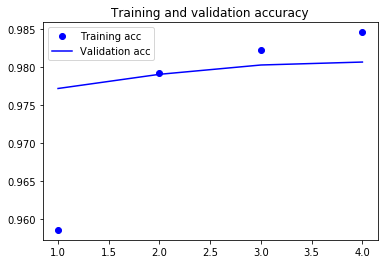

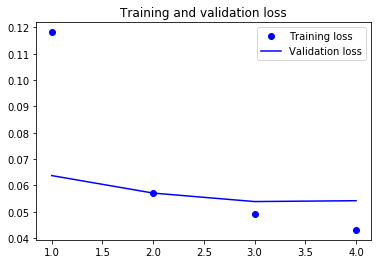

Validation Accuracy:  98.06865712685806
Training Accuracy:  98.46207065857881
0
          0  88304
0      6148     47
88304    98    702 


1
          0  88305
0      1432     97
88305   241   5225 


2
          0  88307
0      5613    120
88307    61   1201 


3
          0  88309
0      6720     37
88309    58    180 


4
          0  88331
0      6669      4
88331     8    314 


5
          0  88341
0      6498     84
88341   189    224 


6
          0  88342
0      5724    135
88342   148    988 


7
          0  88112
0      6995      0
88112     0      0 


8
          0  88141
0      6995      0
88141     0      0 


9
          0  88175
0      6995      0
88175     0      0 


Test accuracy :  98.10293066476055



Running Fold 9 / 10 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 150, 135)          3240000   
___________________________________________

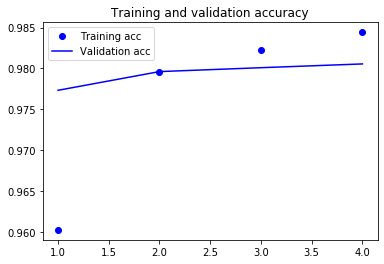

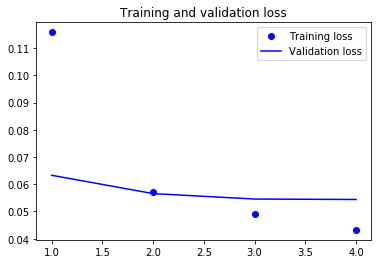

Validation Accuracy:  98.05548668049462
Training Accuracy:  98.44232904877967
0
          0  88304
0      6139     48
88304   123    674 


1
          0  88305
0      1389    133
88305   212   5250 


2
          0  88307
0      5602    122
88307    90   1170 


3
          0  88309
0      6727     25
88309    80    152 


4
          0  88331
0      6658      8
88331    10    308 


5
          0  88341
0      6492     83
88341   166    243 


6
          0  88342
0      5763     91
88342   162    968 


7
          0  88112
0      6983      0
88112     1      0 


8
          0  88141
0      6984      0
88141     0      0 


9
          0  88175
0      6984      0
88175     0      0 


Test accuracy :  98.06128293241694



Running Fold 10 / 10 


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 150, 135)          3240000   
__________________________________________

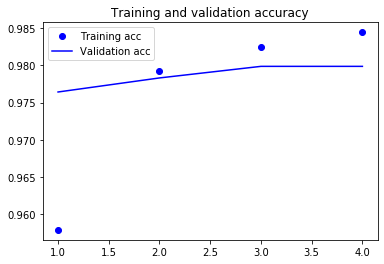

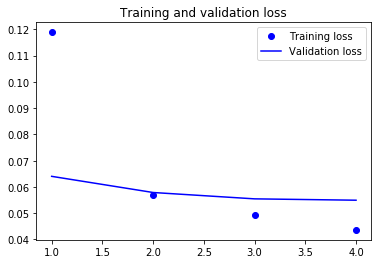

Validation Accuracy:  97.98684088242945
Training Accuracy:  98.44452610474971
0
          0  88304
0      6146     38
88304   111    680 


1
          0  88305
0      1372    147
88305   173   5283 


2
          0  88307
0      5598    126
88307    59   1192 


3
          0  88309
0      6709     37
88309    72    157 


4
          0  88331
0      6648     14
88331     7    306 


5
          0  88341
0      6453    119
88341   148    255 


6
          0  88342
0      5763     88
88342   177    947 


7
          0  88112
0      6975      0
88112     0      0 


8
          0  88141
0      6975      0
88141     0      0 


9
          0  88175
0      6975      0
88175     0      0 


Test accuracy :  98.11326164874552





In [36]:
#get the data as a wholesome x and y with no splits
x, y = convert_text_no_split(data, maxlen, max_words)

#this is really unnessesary....
#really you just need y_new = len(y)
#this is only so that the kfold knows how many labels we have
#kfold cannot split a 2d label so they need to be of the shape 
#(n,) where n is the number of labels

y_new = get_new_labels(y)

#determine number of folds
n_folds = 10

#create a skf
skf = StratifiedKFold(n_splits = n_folds,shuffle=True)

#create a array of indices where each row
#contains two columns (train, test)
#for every row each column is an array of indices that
#split the data into training and test sets
splitted_indices=skf.split(x, y_new)

#for printing purposes
i = 0

#to hold all classification reports
report= []

#grab the train and test indices for each split in splitted indices
for (train, test) in splitted_indices:
    #print the runnin fold
    print("Running Fold", i+1, "/", n_folds, '\n\n')
    i = i + 1
    
    # Clearing the NN.    
    model = None 
    
    #re-create the model
    model = create_model(max_words, maxlen)
    
    #train and evaluate the model
    #split x and y by the train and test indices
    #append the classification report
    report.append(train_and_evaluate_model(model, x[train], y[train], x[test], y[test]))
    print('\n\n')
    
    

In [37]:
for r in report:
    print(r)

              precision    recall  f1-score   support

           0       0.94      0.87      0.90       813
           1       0.98      0.96      0.97      5490
           2       0.91      0.93      0.92      1289
           3       0.82      0.79      0.80       257
           4       0.97      0.95      0.96       344
           5       0.67      0.61      0.64       423
           6       0.90      0.85      0.87      1161
           7       0.00      0.00      0.00         0
           8       0.00      0.00      0.00         0
           9       0.00      0.00      0.00         0

   micro avg       0.94      0.92      0.93      9777
   macro avg       0.62      0.60      0.61      9777
weighted avg       0.94      0.92      0.93      9777
 samples avg       0.96      0.95      0.95      9777

              precision    recall  f1-score   support

           0       0.96      0.84      0.90       810
           1       0.97      0.97      0.97      5485
           2       0.92 